In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from ipywidgets import interact, FloatSlider, fixed
from scipy.stats import norm

## 1. Coin Flip Example: Binomial PMFs and Critical Region

We'll compare two simple hypotheses: $H₀: θ=0.5$ vs $H₁: θ=0.75$. The critical region is determined by the likelihood ratio exceeding a threshold $k$.

> An interactive plot showing two binomial PMFs. The critical region (red dots) updates as you adjust `k_threshold`. $α$ (probability under $H₀$) and $β$ (probability under $H₁$) are displayed.

In [5]:
def plot_likelihood_ratio(n=20, k_threshold=1.0):
    theta0 = 0.5
    theta1 = 0.75
    x = np.arange(0, n+1)
    
    # Likelihoods
    L0 = binom.pmf(x, n, theta0)
    L1 = binom.pmf(x, n, theta1)
    LR = L1 / L0
    
    # Critical region
    critical = x[LR > k_threshold]
    
    # Plotting
    plt.figure(figsize=(10,6))
    plt.stem(x, L0, linefmt='C0-', markerfmt='C0o', basefmt='C0-', label=f'H₀: θ={theta0}')
    plt.stem(x, L1, linefmt='C1--', markerfmt='C1x', basefmt='C1-', label=f'H₁: θ={theta1}')
    plt.scatter(critical, L0[critical], color='red', zorder=5, label='Critical Region')
    plt.xlabel('Number of Successes (k)')
    plt.ylabel('Probability')
    plt.title(f'Likelihood Ratio Test (n={n}, k_threshold={k_threshold})')
    plt.legend()
    
    # Calculate alpha and beta
    alpha = np.sum(L0[critical])
    beta = np.sum(L1[x < critical[0]]) if len(critical) > 0 else 1.0
    plt.text(0.5, 0.95, 
             f'α (Type I error): {alpha:.3f}\nβ (Type II error): {beta:.3f}\nPower (1-β): {1-beta:.3f}',
             transform=plt.gca().transAxes, va='top')
    plt.show()

interact(plot_likelihood_ratio,
         n=fixed(20),
         k_threshold=FloatSlider(min=0.1, max=10, step=0.1, value=1.0));

interactive(children=(FloatSlider(value=1.0, description='k_threshold', max=10.0, min=0.1), Output()), _dom_cl…

## 2. Type I/II Errors with Normal Distributions

Visualize overlapping distributions and error regions using normal distributions.

> Two overlapping normal distributions. Red area ($α$) is Type I error; blue area ($β$) is Type II error. Adjust effect size and $α$ to see how errors change.

In [7]:
def plot_error_regions(effect_size=1.0, alpha=0.05):
    mu0, sigma = 0, 1
    mu1 = mu0 + effect_size
    x = np.linspace(mu0 - 4, mu1 + 4, 1000)
    
    # Distributions
    f0 = norm.pdf(x, mu0, sigma)
    f1 = norm.pdf(x, mu1, sigma)
    
    # Critical value (z-score for alpha)
    critical_val = norm.ppf(1 - alpha, mu0, sigma)
    
    # Error regions
    x_crit = np.linspace(critical_val, mu1 + 4, 100)
    
    plt.figure(figsize=(10,6))
    plt.plot(x, f0, label='H₀')
    plt.plot(x, f1, label='H₁')
    plt.fill_between(x_crit, 0, norm.pdf(x_crit, mu0, sigma), alpha=0.3, color='red', label='Type I (α)')
    plt.fill_between(x[x <= critical_val], 0, norm.pdf(x[x <= critical_val], mu1, sigma),
                     alpha=0.3, color='blue', label='Type II (β)')
    plt.title(f'Type I and II Errors (Effect Size={effect_size}, α={alpha})')
    plt.legend()
    plt.show()

interact(plot_error_regions,
         effect_size=FloatSlider(min=0.5, max=3, step=0.5, value=1.0),
         alpha=FloatSlider(min=0.01, max=0.2, step=0.01, value=0.05));

interactive(children=(FloatSlider(value=1.0, description='effect_size', max=3.0, min=0.5, step=0.5), FloatSlid…

## 3. Neyman-Pearson Lemma Visualization

Compare the optimal critical region $C$ (from LR test) with another region $C_*$ having the same $α$ but lower power.

> Red region ($C$) is the LR-optimal critical region. Green region ($C_*$) has the same α but misses part of the high-likelihood area under $H₁$, leading to higher $β$.

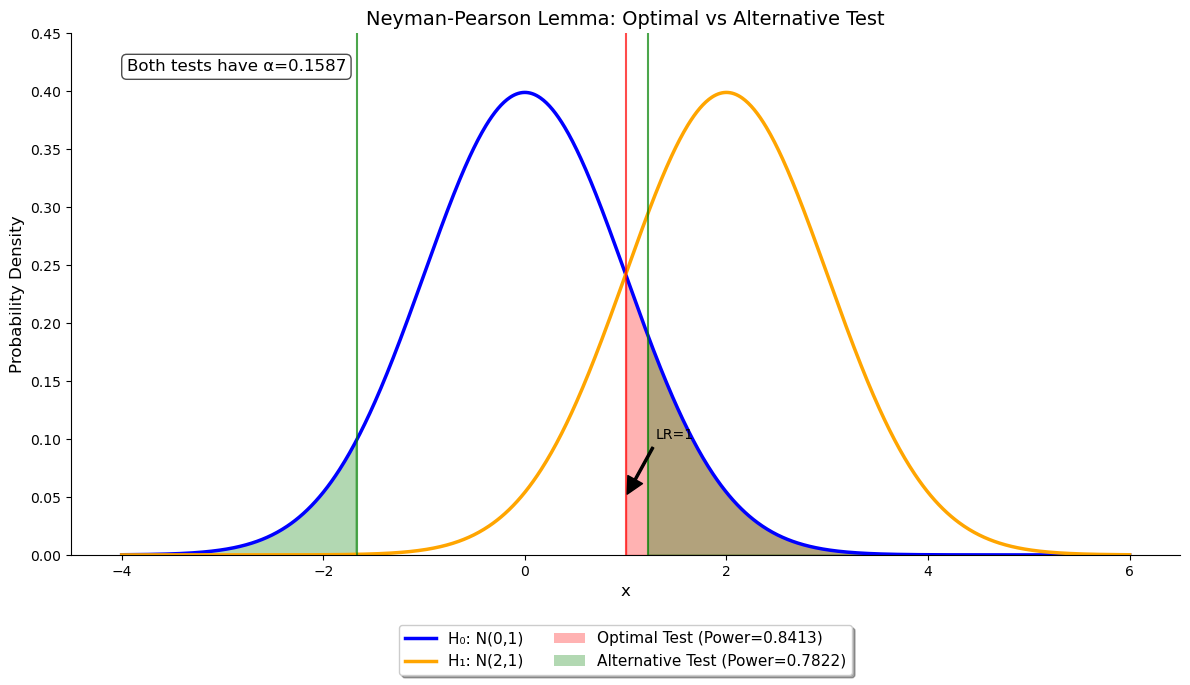

In [11]:
from matplotlib.patches import Patch

def plot_neyman_pearson_clean():
    # Parameters
    mu0, sigma = 0, 1
    mu1 = 2
    x = np.linspace(-4, 6, 1000)
    f0 = norm.pdf(x, mu0, sigma)
    f1 = norm.pdf(x, mu1, sigma)
    
    # Calculate likelihood ratio
    lr = f1/f0
    
    # Optimal critical region (LR > 1)
    mask_optimal = lr > 1
    optimal_boundary = 1.0  # This is where LR = 1 for these normal distributions
    alpha_optimal = norm.sf(optimal_boundary, mu0, sigma)
    
    # Create an alternative test with same α but different critical region
    # Split alpha into two tails
    alpha_right = alpha_optimal * 0.7
    alpha_left = alpha_optimal * 0.3
    
    # Find corresponding boundaries
    right_boundary = norm.ppf(1 - alpha_right, mu0, sigma)
    left_boundary = norm.ppf(alpha_left, mu0, sigma)
    
    # Create mask for alternative critical region
    mask_alt = (x > right_boundary) | (x < left_boundary)
    
    # Calculate power (1-β) for both tests
    power_optimal = 1 - norm.cdf(optimal_boundary, mu1, sigma)
    power_alt = norm.sf(right_boundary, mu1, sigma) + norm.cdf(left_boundary, mu1, sigma)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Plot distributions
    ax.plot(x, f0, 'b-', linewidth=2.5, label='H₀: N(0,1)')
    ax.plot(x, f1, 'orange', linewidth=2.5, label='H₁: N(2,1)')
    
    # Fill optimal region
    ax.fill_between(x, 0, f0, where=mask_optimal, color='red', alpha=0.3)
    
    # Fill alternative region
    ax.fill_between(x, 0, f0, where=mask_alt, color='green', alpha=0.3)
    
    # Add vertical lines at boundaries - use solid lines for better visibility
    ax.axvline(x=optimal_boundary, color='red', linestyle='-', alpha=0.7, linewidth=1.5)
    ax.axvline(x=right_boundary, color='green', linestyle='-', alpha=0.7, linewidth=1.5)
    ax.axvline(x=left_boundary, color='green', linestyle='-', alpha=0.7, linewidth=1.5)
    
    # Annotations - simplified
    ax.annotate('LR=1', xy=(optimal_boundary, 0.05), xytext=(optimal_boundary+0.3, 0.1),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))
    
    # Create custom legend elements
    legend_elements = [
        Patch(facecolor='red', alpha=0.3, label=f'Optimal Test (Power={power_optimal:.4f})'),
        Patch(facecolor='green', alpha=0.3, label=f'Alternative Test (Power={power_alt:.4f})')
    ]
    
    # Add a note about equal alpha
    ax.text(0.05, 0.95, f'Both tests have α={alpha_optimal:.4f}', transform=ax.transAxes, 
            fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # Finalize plot
    ax.set_title('Neyman-Pearson Lemma: Optimal vs Alternative Test', fontsize=14)
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('Probability Density', fontsize=12)
    ax.set_ylim(0, 0.45)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Get handles and labels for both 
    handles, labels = ax.get_legend_handles_labels()
    handles.extend(legend_elements)
    labels.extend([le.get_label() for le in legend_elements])
    
    # Position the legend outside the plot
    ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.12),
              fancybox=True, shadow=True, ncol=2, fontsize=11)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Make room for the legend
    plt.show()

plot_neyman_pearson_clean()

## 4. Interactive Likelihood Ratio Curve

Show how the likelihood ratio changes with sample mean and the critical threshold.

> A curve showing the likelihood ratio as a function of the sample mean. Adjust the sample mean to see how the LR crosses the threshold.

In [16]:
def plot_lr_curve(sample_mean=1.0, sigma=1, n=1):
    theta0 = 0
    theta1 = 1
    x = np.linspace(-3, 3, 100)
    LR = np.exp((n/sigma**2) * (2*sample_mean*(theta1 - theta0) - (theta1**2 - theta0**2)))
    
    plt.figure(figsize=(10,6))
    plt.plot(x, np.exp((n/sigma**2) * (2*x*(theta1 - theta0) - (theta1**2 - theta0**2))), label='Likelihood Ratio')
    plt.axhline(1, color='k', linestyle='--', label='Threshold k=1')
    plt.axvline(sample_mean, color='r', linestyle='--', label='Observed Sample Mean')
    plt.xlabel('Sample Mean')
    plt.ylabel('Likelihood Ratio')
    plt.title('Likelihood Ratio as Function of Sample Mean')
    plt.legend()
    plt.ylim(0, 10)
    plt.show()

interact(plot_lr_curve,
         sample_mean=FloatSlider(min=-2, max=2, step=0.1, value=0.5),
         n=fixed(1))

interactive(children=(FloatSlider(value=0.5, description='sample_mean', max=2.0, min=-2.0), IntSlider(value=1,…

<function __main__.plot_lr_curve(sample_mean=1.0, sigma=1, n=1)>